    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed SciMLSensitivity ─ v7.56.2
    Updating `~/Work/DiffGasNetworks/Project.toml`
  [1ed8b502] + SciMLSensitivity v7.56.2
    Updating `~/Work/DiffGasNetworks/Manifest.toml`
  [1ed8b502] ↑ SciMLSensitivity v7.56.1 ⇒ v7.56.2
Precompiling project...
  ✓ SciMLSensitivity
  1 dependency successfully precompiled in 10 seconds. 435 already precompiled.
  1 dependency precompiled but a different version is currently loaded. Restart julia to access the new version


In [79]:
using Pkg
Pkg.activate("..")
include("ng_network.jl")
using Plots, Zygote, LaTeXStrings, BenchmarkTools

  Activating project at `~/Work/DiffGasNetworks`


In [191]:
# init
dx = 4_000; #m
T = 6 * 3600; # time [s]

basepath = "../network_specs/israel_reduced/";

net = parse_network_from_files(dx,
    basepath * "network_data/pipes.csv",
    basepath * "network_data/nodes.csv",
    basepath * "initial_conditions/pipe_ic.csv",
    basepath * "initial_conditions/node_ic.csv",
    basepath * "network_data/params_scen1.csv",
    density_from_pressure,
    pressure_from_density);

tspan = (0.0, T);
bc_dt = T/6;
sys, prob = create_ode_problem!(net, dx, tspan, bc_dt=bc_dt);

In [192]:
params = 20*randn(length(parameters(sys)))
[params[1:Int(length(params)/2)] params[Int(length(params)/2)+1:end]]

39×2 Matrix{Float64}:
   7.84718    1.69611
  16.7546   -32.81
   7.6167     9.48918
 -32.2368    11.1984
  17.8218    -6.0519
  -3.83349  -26.9445
 -15.4513   -17.648
  12.9955    35.1675
 -10.8593   -13.3319
  17.8446    25.7333
  -4.92719   -0.540691
  26.0937     4.28364
 -17.763     25.9858
   ⋮        
   5.22708   37.3109
  -2.69963   23.7291
   4.62536    2.12183
   5.41264   -4.45143
  38.683    -42.6327
  11.4391    12.7927
 -16.3699    -0.339697
  -9.46911   17.9733
 -21.8812    16.4001
  -3.25166   22.2595
  22.9451    24.8164
 -10.2227    11.6754

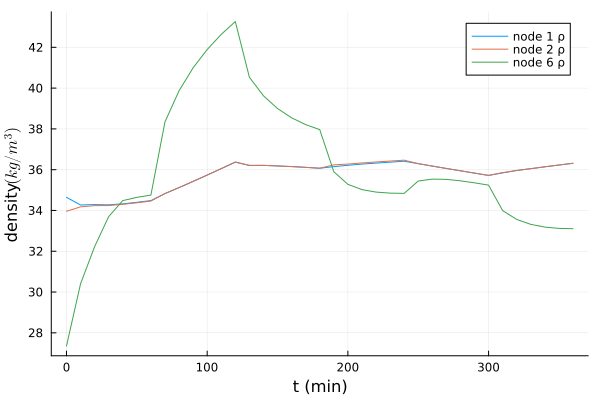

In [193]:
saveat = prob.tspan[1]:60*10:prob.tspan[end]
sol = solve(prob, SSPRK432(), adaptive=true, dt=get_metadata(net, :dt), p=params, saveat=saveat);
plot(sol.t/60, sol[sys.node_1.ρ], xlabel="t (min)", ylabel="density" * L"(kg/m^3)", label="node 1 ρ")
plot!(sol.t/60, sol[sys.node_2.ρ], label="node 2 ρ")
plot!(sol.t/60, sol[sys.node_6.ρ], label="node 6 ρ")

suggested dt = 0.048399032014519804


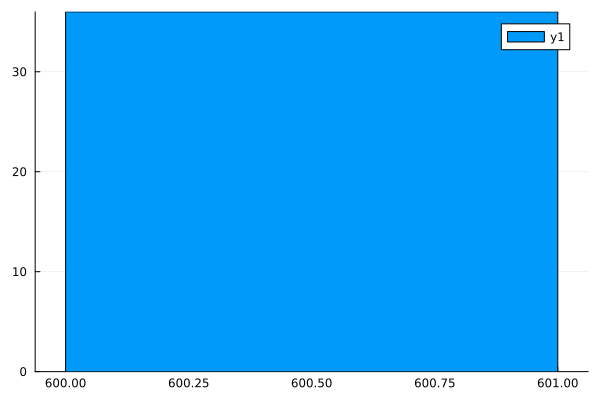

In [145]:
println("suggested dt = $(get_metadata(net, :dt))")
histogram(sol.t[2:end]-sol.t[1:end-1])

In [185]:
using SciMLSensitivity
loss(p) = solve(prob, SSPRK43(), p=p, sensealg=InterpolatingAdjoint())[end][1]
loss(params)

32.525718393681835

In [194]:
@benchmark solve(prob, SSPRK43(), p=params, sensealg=InterpolatingAdjoint())

BenchmarkTools.Trial: 332 samples with 1 evaluation.
 Range (min … max):  11.322 ms … 38.542 ms  ┊ GC (min … max):  0.00% … 59.03%
 Time  (median):     12.886 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   15.089 ms ±  6.369 ms  ┊ GC (mean ± σ):  14.31% ± 19.00%

     █▇▂                                                       
  ▆██████▅▅▁▄▄▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▄▁▁▁▄▄▆▆▇▇▅█ ▆
  11.3 ms      Histogram: log(frequency) by time      34.7 ms <

 Memory estimate: 33.45 MiB, allocs estimate: 20068.

In [195]:
@benchmark gradient(loss, params)

BenchmarkTools.Trial: 19 samples with 1 evaluation.
 Range (min … max):  258.729 ms … 292.996 ms  ┊ GC (min … max): 0.00% … 9.72%
 Time  (median):     261.331 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   270.609 ms ±  13.398 ms  ┊ GC (mean ± σ):  3.52% ± 4.47%

      █                                                          
  ▄▄▄▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▄▁▁▁▄▆▁▁▁▁▁▁▄▁▁▄ ▁
  259 ms           Histogram: frequency by time          293 ms <

 Memory estimate: 126.41 MiB, allocs estimate: 570029.